### Task 1: CNN Model for Pizza vs. Non-Pizza Classification

#### Model Definition

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the CNN model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')  
    ])
    return model

model = create_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

### Data Preparation and Splitting

In [3]:
from sklearn.model_selection import train_test_split
import os
import numpy as np
import shutil


data_dir = 'pizza_not_pizza'
pizza_dir = os.path.join(data_dir, 'pizza')
non_pizza_dir = os.path.join(data_dir, 'not_pizza')


if not os.path.exists('data'):
    os.makedirs('data/train/pizza')
    os.makedirs('data/train/not_pizza')
    os.makedirs('data/test/pizza')
    os.makedirs('data/test/not_pizza')


pizza_files = [os.path.join(pizza_dir, f) for f in os.listdir(pizza_dir)]
non_pizza_files = [os.path.join(non_pizza_dir, f) for f in os.listdir(non_pizza_dir)]


train_pizza, test_pizza = train_test_split(pizza_files, test_size=0.2, random_state=42)
train_non_pizza, test_non_pizza = train_test_split(non_pizza_files, test_size=0.2, random_state=42)


for f in train_pizza:
    shutil.copy(f, 'data/train/pizza')
for f in test_pizza:
    shutil.copy(f, 'data/test/pizza')
for f in train_non_pizza:
    shutil.copy(f, 'data/train/not_pizza')
for f in test_non_pizza:
    shutil.copy(f, 'data/test/not_pizza')

### Training the Model

In [4]:
# ImageDataGenerators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

Found 1572 images belonging to 2 classes.
Found 394 images belonging to 2 classes.
Epoch 1/10
50/50 [==============================] - 5s 89ms/step - loss: 0.6820 - accuracy: 0.5522 - val_loss: 0.6224 - val_accuracy: 0.6878
Epoch 2/10
50/50 [==============================] - 4s 79ms/step - loss: 0.5943 - accuracy: 0.6864 - val_loss: 0.5485 - val_accuracy: 0.7081
Epoch 3/10
50/50 [==============================] - 4s 80ms/step - loss: 0.5258 - accuracy: 0.7513 - val_loss: 0.4983 - val_accuracy: 0.7716
Epoch 4/10
50/50 [==============================] - 4s 86ms/step - loss: 0.5766 - accuracy: 0.7131 - val_loss: 0.4765 - val_accuracy: 0.7868
Epoch 5/10
50/50 [==============================] - 4s 82ms/step - loss: 0.5206 - accuracy: 0.7525 - val_loss: 0.5332 - val_accuracy: 0.7640
Epoch 6/10
50/50 [==============================] - 4s 80ms/step - loss: 0.4985 - accuracy: 0.7678 - val_loss: 0.4593 - val_accuracy: 0.8071
Epoch 7/10
50/50 [==============================] - 4s 79ms/step - loss

### Testing and Visualization

1/1 [==============================] - 0s 19ms/step


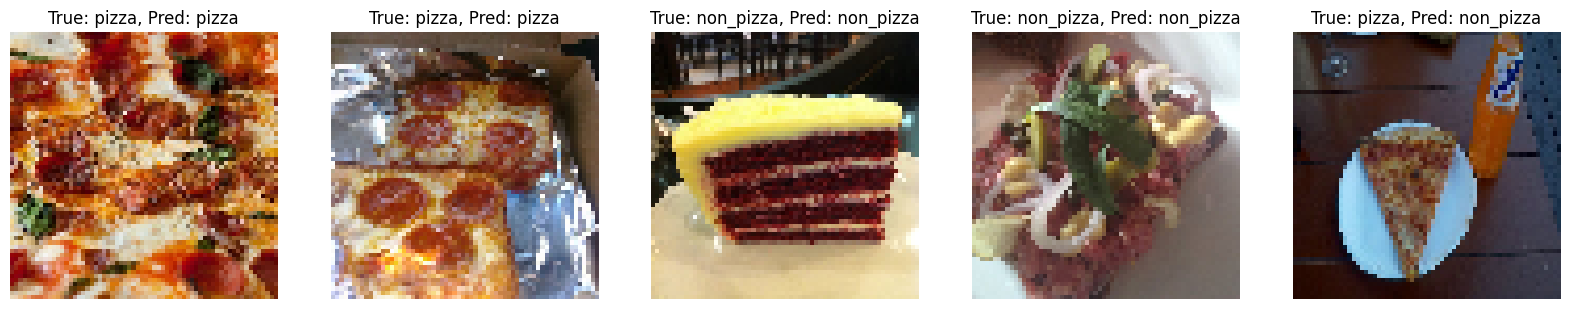

In [7]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(model, generator, class_names):
    x, y = next(generator)
    preds = model.predict(x)
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    for i in range(5):
        ax = axes[i]
        ax.imshow(x[i])
        pred_label = class_names[np.argmax(preds[i])]
        true_label = class_names[int(y[i])]
        ax.set_title(f'True: {true_label}, Pred: {pred_label}')
        ax.axis('off')

class_names = ['non_pizza', 'pizza']
visualize_predictions(model, test_generator, class_names)

### Task 2: Transfer Learning Model with Moderate-Level Dataset


#### Step 1: Problem Statement
We will use transfer learning with a pre-trained model (VGG16) to classify images from the CIFAR-10 dataset.

#### Step 2: Data Loading
Download and load the CIFAR-10 dataset.

In [8]:
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


x_train, x_test = x_train / 255.0, x_test / 255.0


y_train, y_test = tf.keras.utils.to_categorical(y_train, 10), tf.keras.utils.to_categorical(y_test, 10)


170498071/170498071 [==============================] - 39s 0us/step


#### Step 3: Model Definition
We'll use VGG16 as the base model and add custom layers on top.

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 [==============================] - 12s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                             

#### Step 4: Training the Model
Train the model on the CIFAR-10 training set.

In [10]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 162s 104ms/step - loss: 1.4391 - accuracy: 0.4925 - val_loss: 1.2712 - val_accuracy: 0.5526
Epoch 2/10
1563/1563 [==============================] - 181s 116ms/step - loss: 1.2673 - accuracy: 0.5532 - val_loss: 1.1955 - val_accuracy: 0.5833
Epoch 3/10
1563/1563 [==============================] - 184s 118ms/step - loss: 1.2130 - accuracy: 0.5741 - val_loss: 1.1803 - val_accuracy: 0.5806
Epoch 4/10
1563/1563 [==============================] - 183s 117ms/step - loss: 1.1799 - accuracy: 0.5863 - val_loss: 1.1460 - val_accuracy: 0.5945
Epoch 5/10
1563/1563 [==============================] - 185s 118ms/step - loss: 1.1572 - accuracy: 0.5957 - val_loss: 1.1411 - val_accuracy: 0.5982
Epoch 6/10
1563/1563 [==============================] - 186s 119ms/step - loss: 1.1293 - accuracy: 0.6028 - val_loss: 1.1258 - val_accuracy: 0.6060
Epoch 7/10
1563/1563 [==============================] - 192s 123ms/step - loss: 1.1099 - accuracy: 0.6098 - val_

#### Step 5: Testing and Visualization
Visualize a few images along with their predicted and actual labels.

313/313 [==============================] - 29s 93ms/step


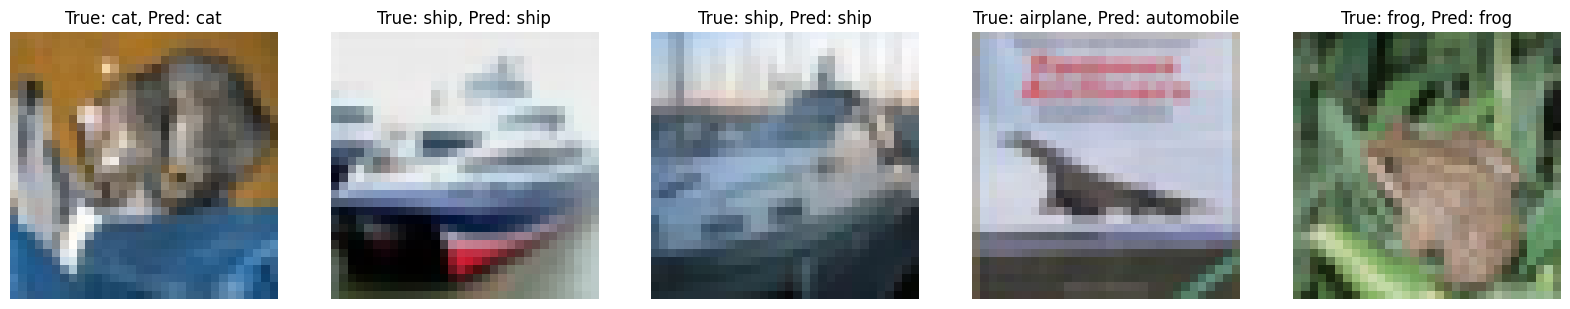

In [11]:
def visualize_predictions(model, x_test, y_test, class_names):
    preds = model.predict(x_test)
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    for i in range(5):
        ax = axes[i]
        ax.imshow(x_test[i])
        pred_label = class_names[np.argmax(preds[i])]
        true_label = class_names[np.argmax(y_test[i])]
        ax.set_title(f'True: {true_label}, Pred: {pred_label}')
        ax.axis('off')

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
visualize_predictions(model, x_test, y_test, class_names)
